In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', 500)

In [3]:
from utils import load_fold
from utils import outer_product
from utils import group_data
from utils import sklearn_train_test_split
from utils import create_model
from utils import get_random_batch
from imblearn.under_sampling import RandomUnderSampler
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint
from utils import evaluate_metrics
from utils import plot_losses

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
fold = 3
train, test, test_fold = load_fold('Raw', fold)
X_train, y_train = group_data(outer_product(train))
X_test, y_test = group_data(outer_product(test))
X_tra, X_val, y_tra, y_val = sklearn_train_test_split(
                X_train, y_train, 0.1, random_state=42,
                shuffle=True, stratify=y_train)

Test fold: Erk.csv
Train fold: CTNNB1.csv
Train fold: LEF1.csv
Train fold: Jnk.csv
Train fold: IRF4.csv
Train fold: MYC.csv
Train fold: Ikk2.csv


In [37]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Activation

def create_custom_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(9, 9, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    
#     model.add(Conv2D(32, (3, 3), strides=2))
#     model.add(Activation('relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    
#     model.add(Conv2D(32, (1, 1)))
#     model.add(Activation('relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    
#     model.add(Conv2D(64, (3, 3)))
#     model.add(Activation('relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
       
#     model.add(GlobalAveragePooling2D())

    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [59]:
# results_train = pd.DataFrame()
# results_val = pd.DataFrame()
# results_test = pd.DataFrame()
results = pd.DataFrame()
histories = []
models = []
random_state = np.random.RandomState(seed=42)

In [45]:
from utils import fit_base_learner
df_train, df_val, df_test, history, model = fit_base_learner(
    X_tra, y_tra, X_val, y_val, test_fold, X_test, y_test, 
    create_custom_model, random_state, 'CvReBnFlDeReBnDe')

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Confusion matrix:
[[14232  1530]
 [  879 14883]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.978668  0.923351  0.925128  0.944233  0.902931  0.923582   

   Precision    Recall  Logloss       Description  
0   0.906781  0.944233      NaN  CvReBnFlDeReBnDe  
Confusion matrix:
[[1248  504]
 [ 482 1270]]
  Model     Fold   ROC-AUC   G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.782594  0.71858  0.720363  0.724886  0.712329  0.718607   

   Precision    Recall   Logloss       Description  
0   0.715896  0.724886  0.944661  CvReBnFlDeReBnDe  
Confusion matrix:
[[95396 45070]
 [  149   115]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.572546  0.543909  0.005061  0.435606  0.679139  0.678683   

   Precision    Recall  Logloss       Description  
0   0.002545  0.435606      NaN  CvReBnFlDeReBnDe  


In [62]:
def append_results(results, df_train, df_val, df_test):
    col_order = ['Results'] + [col for col in df_train.columns if col != 'Results']
    df_train['Results'] = 'train'
    df_val['Results'] = 'valid'
    df_test['Results'] = 'test'
    return pd.concat((results, df_train, df_val, df_test))[col_order]

In [63]:
results = append_results(results, df_train, df_val, df_test)

In [64]:
results

,Results,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,train,CNN,Erk.csv,0.978668,0.923351,0.925128,0.944233,0.902931,0.923582,0.906781,0.944233,NaN,CvReBnFlDeReBnDe
0,valid,CNN,Erk.csv,0.782594,0.718580,0.720363,0.724886,0.712329,0.718607,0.715896,0.724886,0.944661,CvReBnFlDeReBnDe
0,test,CNN,Erk.csv,0.572546,0.543909,0.005061,0.435606,0.679139,0.678683,0.002545,0.435606,NaN,CvReBnFlDeReBnDe


In [46]:
histories.append(history)
models.append(model)

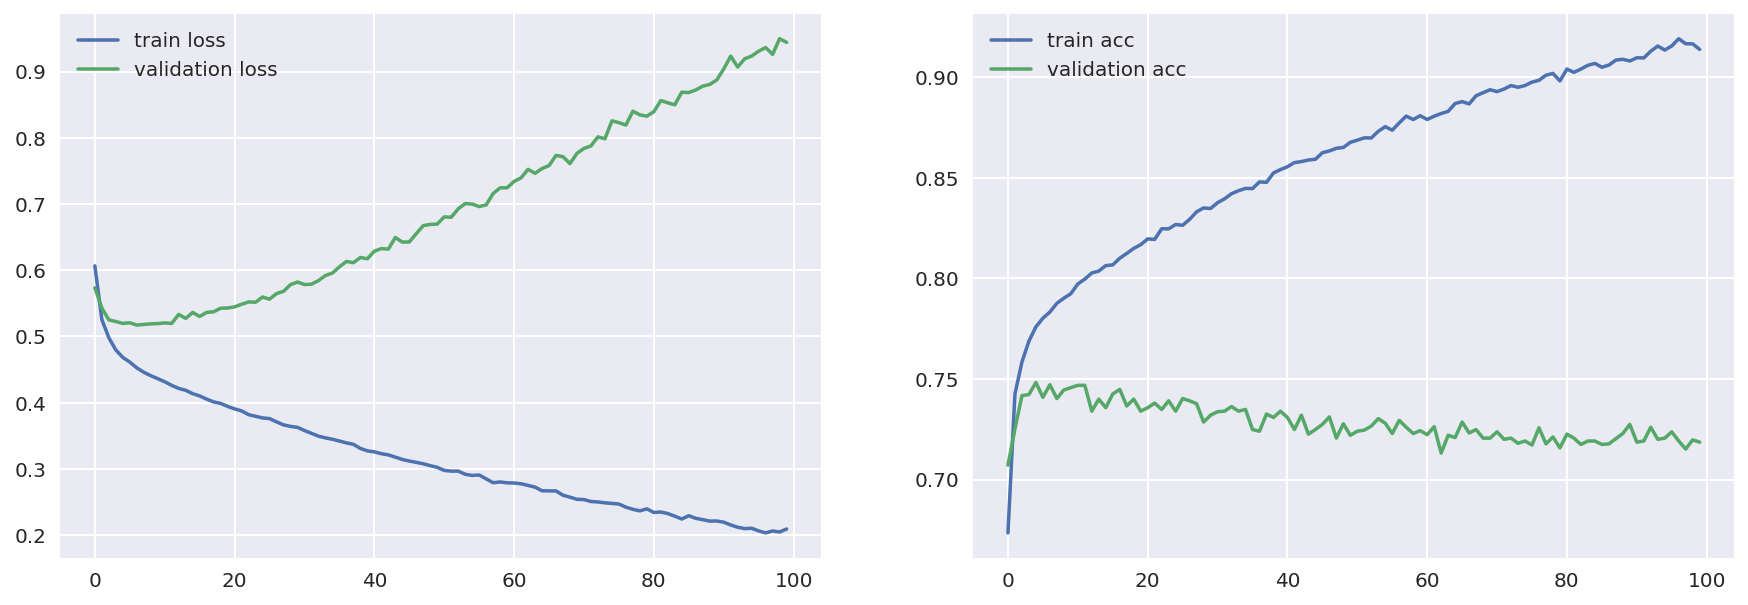

In [68]:
from utils import plot_losses
plot_losses(history.history['loss'], history.history['val_loss'], 
            history.history['acc'], history.history['val_acc'], 1)

In [182]:
def create_custom_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(9, 9, 1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [183]:
create_custom_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 9, 9, 16)          160       
_________________________________________________________________
flatten_32 (Flatten)         (None, 1296)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 1297      
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________


In [72]:
random_state = np.random.RandomState(seed=42)
from utils import fit_base_learner
df_train, df_val, df_test, history, model = fit_base_learner(
    X_tra, y_tra, X_val, y_val, test_fold, X_test, y_test, 
    create_custom_model, random_state, 'CvFlDe')

Confusion matrix:
[[9644 6118]
 [6686 9076]]
  Model     Fold   ROC-AUC   G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.640677  0.59356  0.586381  0.575815  0.611851  0.593833   

   Precision    Recall   Logloss Description  
0   0.597341  0.575815  0.660544      CvFlDe  
Confusion matrix:
[[1099  653]
 [ 749 1003]]
  Model     Fold   ROC-AUC   G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.637547  0.59926  0.588615  0.572489  0.627283  0.599886   

   Precision    Recall  Logloss Description  
0   0.605676  0.572489  0.66345      CvFlDe  
Confusion matrix:
[[77169 63297]
 [  136   128]]
  Model     Fold  ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.54504  0.516106   0.00402  0.484848  0.549378  0.549257   

   Precision    Recall   Logloss Description  
0   0.002018  0.484848  0.750034      CvFlDe  


In [73]:
results = append_results(results, df_train, df_val, df_test)
results

,Results,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,train,CNN,Erk.csv,0.978668,0.923351,0.925128,0.944233,0.902931,0.923582,0.906781,0.944233,NaN,CvReBnFlDeReBnDe
0,valid,CNN,Erk.csv,0.782594,0.718580,0.720363,0.724886,0.712329,0.718607,0.715896,0.724886,0.944661,CvReBnFlDeReBnDe
0,test,CNN,Erk.csv,0.572546,0.543909,0.005061,0.435606,0.679139,0.678683,0.002545,0.435606,NaN,CvReBnFlDeReBnDe
0,train,CNN,Erk.csv,0.640677,0.593560,0.586381,0.575815,0.611851,0.593833,0.597341,0.575815,0.660544,CvFlDe
0,valid,CNN,Erk.csv,0.637547,0.599260,0.588615,0.572489,0.627283,0.599886,0.605676,0.572489,0.663450,CvFlDe
0,test,CNN,Erk.csv,0.545040,0.516106,0.004020,0.484848,0.549378,0.549257,0.002018,0.484848,0.750034,CvFlDe


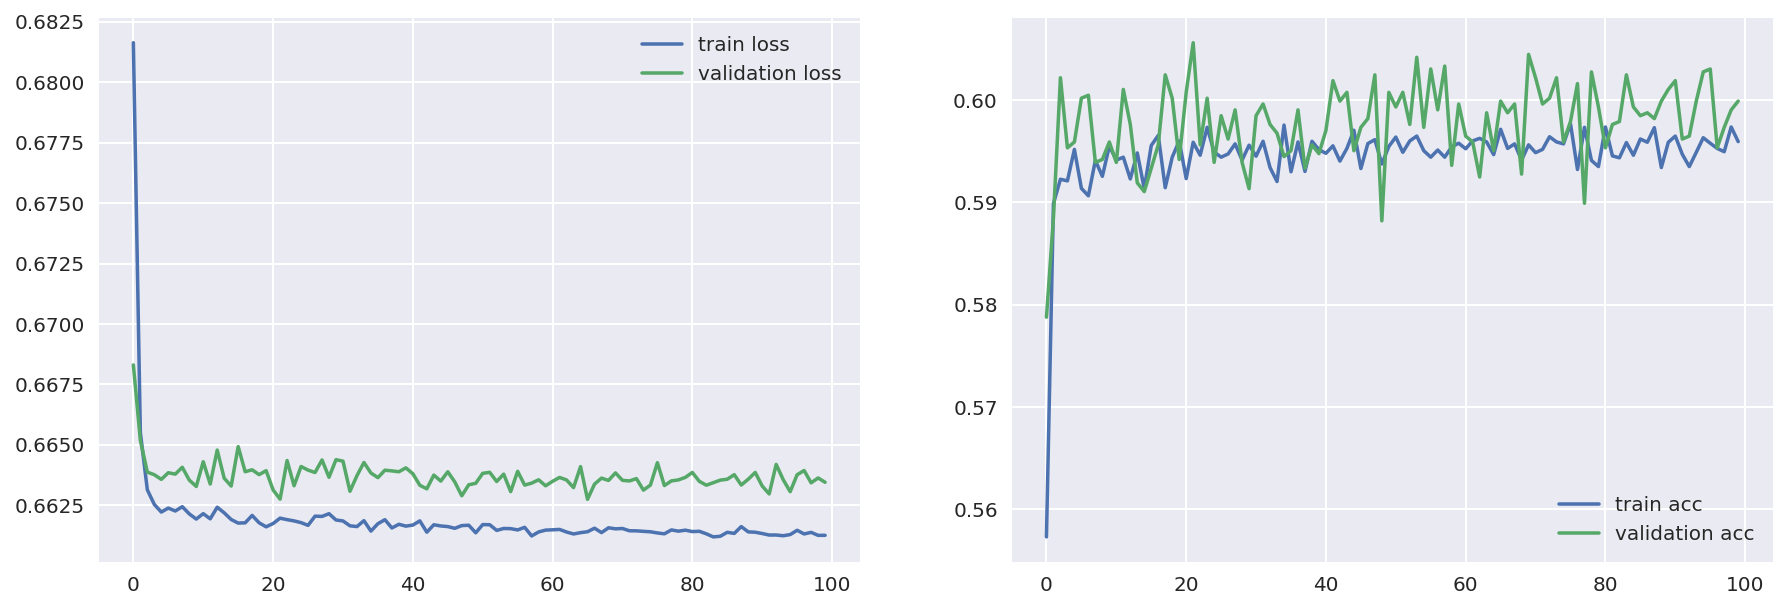

In [74]:
plot_losses(history.history['loss'], history.history['val_loss'], 
            history.history['acc'], history.history['val_acc'], 1)

In [75]:
def create_custom_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(9, 9, 1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [76]:
random_state = np.random.RandomState(seed=42)
from utils import fit_base_learner
df_train, df_val, df_test, history, model = fit_base_learner(
    X_tra, y_tra, X_val, y_val, test_fold, X_test, y_test, 
    create_custom_model, random_state, 'CvReFlDe')

Confusion matrix:
[[10836  4926]
 [ 2428 13334]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.846924  0.762612  0.783846  0.845959  0.687476  0.766717   

   Precision    Recall   Logloss Description  
0    0.73023  0.845959  0.476779    CvReFlDe  
Confusion matrix:
[[1166  586]
 [ 332 1420]]
  Model     Fold  ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.81417  0.734445  0.755721  0.810502  0.665525  0.738014   

   Precision    Recall   Logloss Description  
0   0.707876  0.810502  0.518394    CvReFlDe  
Confusion matrix:
[[113382  27084]
 [   196     68]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.545072  0.455973  0.004961  0.257576  0.807185  0.806154   

   Precision    Recall   Logloss Description  
0   0.002504  0.257576  0.500473    CvReFlDe  


In [77]:
results = append_results(results, df_train, df_val, df_test)
results

,Results,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,train,CNN,Erk.csv,0.978668,0.923351,0.925128,0.944233,0.902931,0.923582,0.906781,0.944233,NaN,CvReBnFlDeReBnDe
0,valid,CNN,Erk.csv,0.782594,0.718580,0.720363,0.724886,0.712329,0.718607,0.715896,0.724886,0.944661,CvReBnFlDeReBnDe
0,test,CNN,Erk.csv,0.572546,0.543909,0.005061,0.435606,0.679139,0.678683,0.002545,0.435606,NaN,CvReBnFlDeReBnDe
0,train,CNN,Erk.csv,0.640677,0.593560,0.586381,0.575815,0.611851,0.593833,0.597341,0.575815,0.660544,CvFlDe
0,valid,CNN,Erk.csv,0.637547,0.599260,0.588615,0.572489,0.627283,0.599886,0.605676,0.572489,0.663450,CvFlDe
0,test,CNN,Erk.csv,0.545040,0.516106,0.004020,0.484848,0.549378,0.549257,0.002018,0.484848,0.750034,CvFlDe
0,train,CNN,Erk.csv,0.846924,0.762612,0.783846,0.845959,0.687476,0.766717,0.730230,0.845959,0.476779,CvReFlDe
0,valid,CNN,Erk.csv,0.814170,0.734445,0.755721,0.810502,0.665525,0.738014,0.707876,0.810502,0.518394,CvReFlDe
0,test,CNN,Erk.csv,0.545072,0.455973,0.004961,0.257576,0.807185,0.806154,0.002504,0.257576,0.500473,CvReFlDe


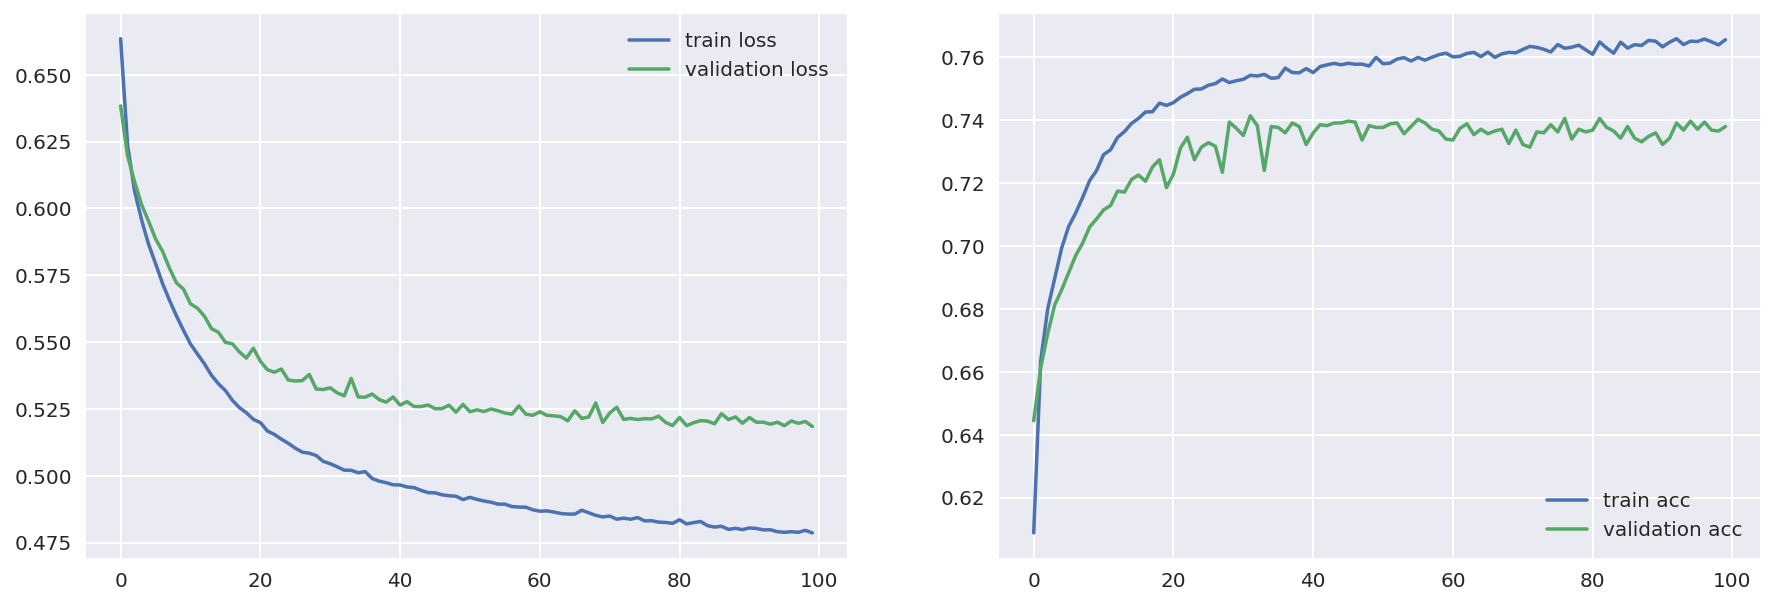

In [78]:
plot_losses(history.history['loss'], history.history['val_loss'], 
            history.history['acc'], history.history['val_acc'], 1)

In [79]:
def create_custom_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(9, 9, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [80]:
random_state = np.random.RandomState(seed=42)
from utils import fit_base_learner
df_train, df_val, df_test, history, model = fit_base_learner(
    X_tra, y_tra, X_val, y_val, test_fold, X_test, y_test, 
    create_custom_model, random_state, 'CvReBnFlDe')

Confusion matrix:
[[11117  4645]
 [ 2547 13215]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.854442  0.768982  0.786092  0.838409  0.705304  0.771856   

   Precision    Recall   Logloss Description  
0   0.739922  0.838409  0.467133  CvReBnFlDe  
Confusion matrix:
[[1185  567]
 [ 369 1383]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR      TNR  Accuracy  \
0   CNN  Erk.csv  0.812522  0.730695  0.747164  0.789384  0.67637  0.732877   

   Precision    Recall   Logloss Description  
0   0.709231  0.789384  0.517824  CvReBnFlDe  
Confusion matrix:
[[114757  25709]
 [   187     77]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.556591  0.488143  0.005912  0.291667  0.816974  0.815988   

   Precision    Recall   Logloss Description  
0   0.002986  0.291667  0.411491  CvReBnFlDe  


In [81]:
results = append_results(results, df_train, df_val, df_test)
results

,Results,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,train,CNN,Erk.csv,0.978668,0.923351,0.925128,0.944233,0.902931,0.923582,0.906781,0.944233,NaN,CvReBnFlDeReBnDe
0,valid,CNN,Erk.csv,0.782594,0.718580,0.720363,0.724886,0.712329,0.718607,0.715896,0.724886,0.944661,CvReBnFlDeReBnDe
0,test,CNN,Erk.csv,0.572546,0.543909,0.005061,0.435606,0.679139,0.678683,0.002545,0.435606,NaN,CvReBnFlDeReBnDe
0,train,CNN,Erk.csv,0.640677,0.593560,0.586381,0.575815,0.611851,0.593833,0.597341,0.575815,0.660544,CvFlDe
0,valid,CNN,Erk.csv,0.637547,0.599260,0.588615,0.572489,0.627283,0.599886,0.605676,0.572489,0.663450,CvFlDe
0,test,CNN,Erk.csv,0.545040,0.516106,0.004020,0.484848,0.549378,0.549257,0.002018,0.484848,0.750034,CvFlDe
0,train,CNN,Erk.csv,0.846924,0.762612,0.783846,0.845959,0.687476,0.766717,0.730230,0.845959,0.476779,CvReFlDe
0,valid,CNN,Erk.csv,0.814170,0.734445,0.755721,0.810502,0.665525,0.738014,0.707876,0.810502,0.518394,CvReFlDe
0,test,CNN,Erk.csv,0.545072,0.455973,0.004961,0.257576,0.807185,0.806154,0.002504,0.257576,0.500473,CvReFlDe
0,train,CNN,Erk.csv,0.854442,0.768982,0.786092,0.838409,0.705304,0.771856,0.739922,0.838409,0.467133,CvReBnFlDe


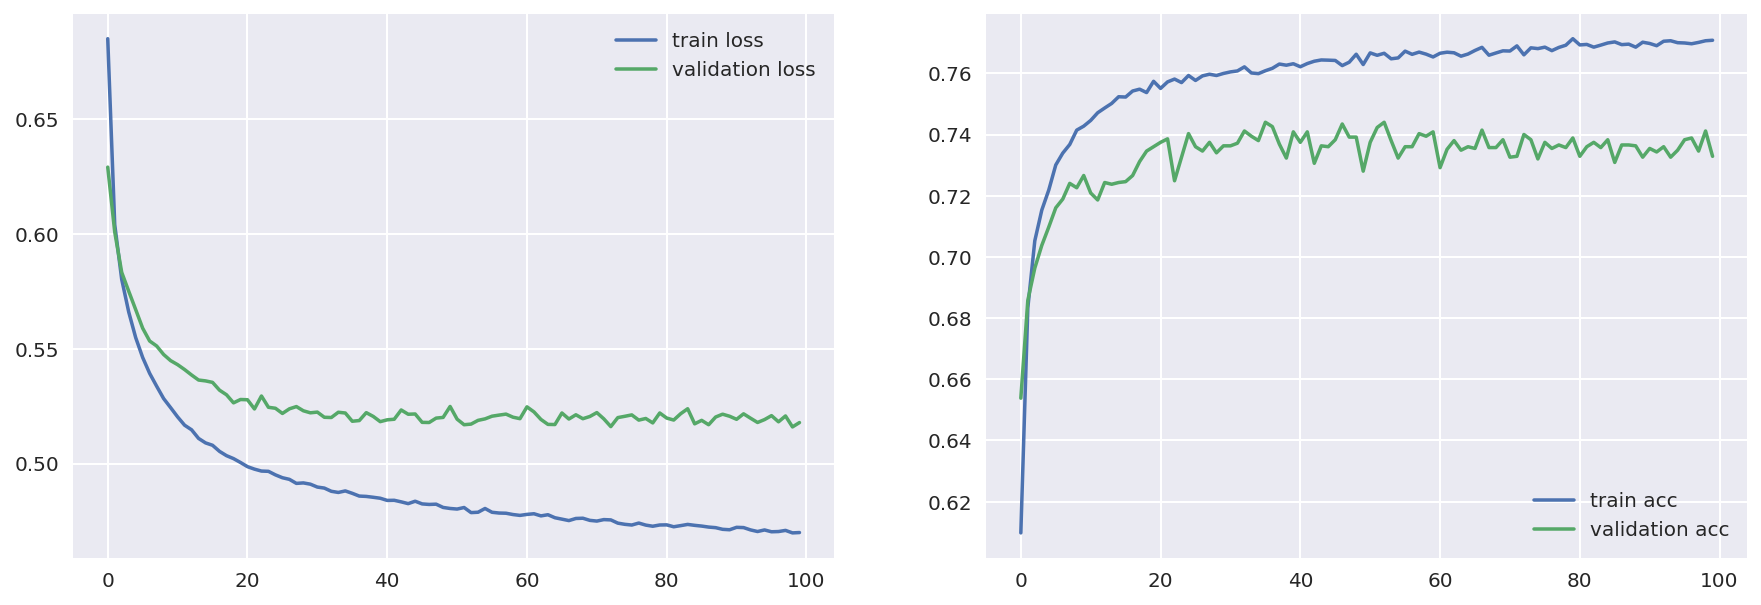

In [82]:
plot_losses(history.history['loss'], history.history['val_loss'], 
            history.history['acc'], history.history['val_acc'], 1)

In [83]:
def create_custom_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(9, 9, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [84]:
random_state = np.random.RandomState(seed=42)
from utils import fit_base_learner
df_train, df_val, df_test, history, model = fit_base_learner(
    X_tra, y_tra, X_val, y_val, test_fold, X_test, y_test, 
    create_custom_model, random_state, 'CvReBnFlDeReBnDe')

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Confusion matrix:
[[14288  1474]
 [  796 14966]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.979215  0.927742  0.929507  0.949499  0.906484  0.927991   

   Precision    Recall  Logloss       Description  
0   0.910341  0.949499      NaN  CvReBnFlDeReBnDe  
Confusion matrix:
[[1212  540]
 [ 483 1269]]
  Model     Fold  ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.77237  0.707861  0.712721  0.724315  0.691781  0.708048   

   Precision    Recall  Logloss       Description  
0   0.701493  0.724315      NaN  CvReBnFlDeReBnDe  
Confusion matrix:
[[101086  39380]
 [   173     91]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.531551  0.498057   0.00458  0.344697  0.719647  0.718944   

   Precision    Recall  Logloss       Description  
0   0.002305  0.344697      inf  CvReBnFlDeReBnDe  


In [85]:
results = append_results(results, df_train, df_val, df_test)
results

,Results,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,train,CNN,Erk.csv,0.978668,0.923351,0.925128,0.944233,0.902931,0.923582,0.906781,0.944233,NaN,CvReBnFlDeReBnDe
0,valid,CNN,Erk.csv,0.782594,0.718580,0.720363,0.724886,0.712329,0.718607,0.715896,0.724886,0.944661,CvReBnFlDeReBnDe
0,test,CNN,Erk.csv,0.572546,0.543909,0.005061,0.435606,0.679139,0.678683,0.002545,0.435606,NaN,CvReBnFlDeReBnDe
0,train,CNN,Erk.csv,0.640677,0.593560,0.586381,0.575815,0.611851,0.593833,0.597341,0.575815,0.660544,CvFlDe
0,valid,CNN,Erk.csv,0.637547,0.599260,0.588615,0.572489,0.627283,0.599886,0.605676,0.572489,0.663450,CvFlDe
0,test,CNN,Erk.csv,0.545040,0.516106,0.004020,0.484848,0.549378,0.549257,0.002018,0.484848,0.750034,CvFlDe
0,train,CNN,Erk.csv,0.846924,0.762612,0.783846,0.845959,0.687476,0.766717,0.730230,0.845959,0.476779,CvReFlDe
0,valid,CNN,Erk.csv,0.814170,0.734445,0.755721,0.810502,0.665525,0.738014,0.707876,0.810502,0.518394,CvReFlDe
0,test,CNN,Erk.csv,0.545072,0.455973,0.004961,0.257576,0.807185,0.806154,0.002504,0.257576,0.500473,CvReFlDe
0,train,CNN,Erk.csv,0.854442,0.768982,0.786092,0.838409,0.705304,0.771856,0.739922,0.838409,0.467133,CvReBnFlDe


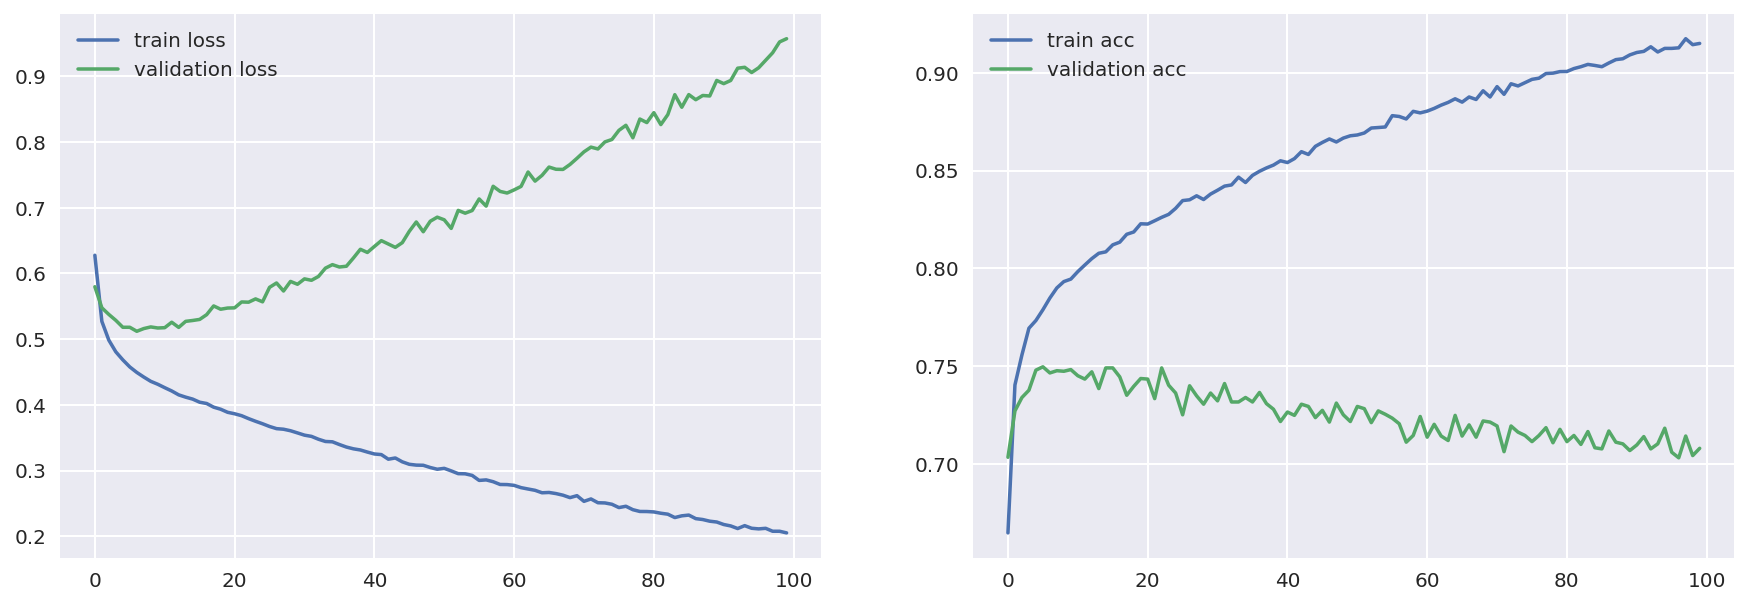

In [86]:
plot_losses(history.history['loss'], history.history['val_loss'], 
            history.history['acc'], history.history['val_acc'], 1)

In [91]:
def create_custom_model():
    model = Sequential()
#     model.add(Conv2D(16, (3, 3), padding='same', input_shape=(9, 9, 1)))
#     model.add(Activation('relu'))
#     model.add(BatchNormalization())
    model.add(Flatten(input_shape=(9, 9, 1)))
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [92]:
random_state = np.random.RandomState(seed=42)
from utils import fit_base_learner
df_train, df_val, df_test, history, model = fit_base_learner(
    X_tra, y_tra, X_val, y_val, test_fold, X_test, y_test, 
    create_custom_model, random_state, 'FlDeReBnDe')

Confusion matrix:
[[11797  3965]
 [ 2826 12936]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.867871  0.783744  0.792089  0.820708  0.748446  0.784577   

   Precision    Recall   Logloss       Description  
0   0.765398  0.820708  0.450002  CvReBnFlDeReBnDe  
Confusion matrix:
[[1245  507]
 [ 460 1292]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.798536  0.723905  0.727682  0.737443  0.710616   0.72403   

   Precision    Recall   Logloss       Description  
0   0.718177  0.737443  0.557034  CvReBnFlDeReBnDe  
Confusion matrix:
[[107438  33028]
 [   176     88]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.574072  0.504932  0.005273  0.333333  0.764868  0.764059   

   Precision    Recall   Logloss       Description  
0   0.002657  0.333333  0.520992  CvReBnFlDeReBnDe  


In [93]:
results = append_results(results, df_train, df_val, df_test)
results

,Results,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,train,CNN,Erk.csv,0.978668,0.923351,0.925128,0.944233,0.902931,0.923582,0.906781,0.944233,NaN,CvReBnFlDeReBnDe
0,valid,CNN,Erk.csv,0.782594,0.718580,0.720363,0.724886,0.712329,0.718607,0.715896,0.724886,0.944661,CvReBnFlDeReBnDe
0,test,CNN,Erk.csv,0.572546,0.543909,0.005061,0.435606,0.679139,0.678683,0.002545,0.435606,NaN,CvReBnFlDeReBnDe
0,train,CNN,Erk.csv,0.640677,0.593560,0.586381,0.575815,0.611851,0.593833,0.597341,0.575815,0.660544,CvFlDe
0,valid,CNN,Erk.csv,0.637547,0.599260,0.588615,0.572489,0.627283,0.599886,0.605676,0.572489,0.663450,CvFlDe
0,test,CNN,Erk.csv,0.545040,0.516106,0.004020,0.484848,0.549378,0.549257,0.002018,0.484848,0.750034,CvFlDe
0,train,CNN,Erk.csv,0.846924,0.762612,0.783846,0.845959,0.687476,0.766717,0.730230,0.845959,0.476779,CvReFlDe
0,valid,CNN,Erk.csv,0.814170,0.734445,0.755721,0.810502,0.665525,0.738014,0.707876,0.810502,0.518394,CvReFlDe
0,test,CNN,Erk.csv,0.545072,0.455973,0.004961,0.257576,0.807185,0.806154,0.002504,0.257576,0.500473,CvReFlDe
0,train,CNN,Erk.csv,0.854442,0.768982,0.786092,0.838409,0.705304,0.771856,0.739922,0.838409,0.467133,CvReBnFlDe


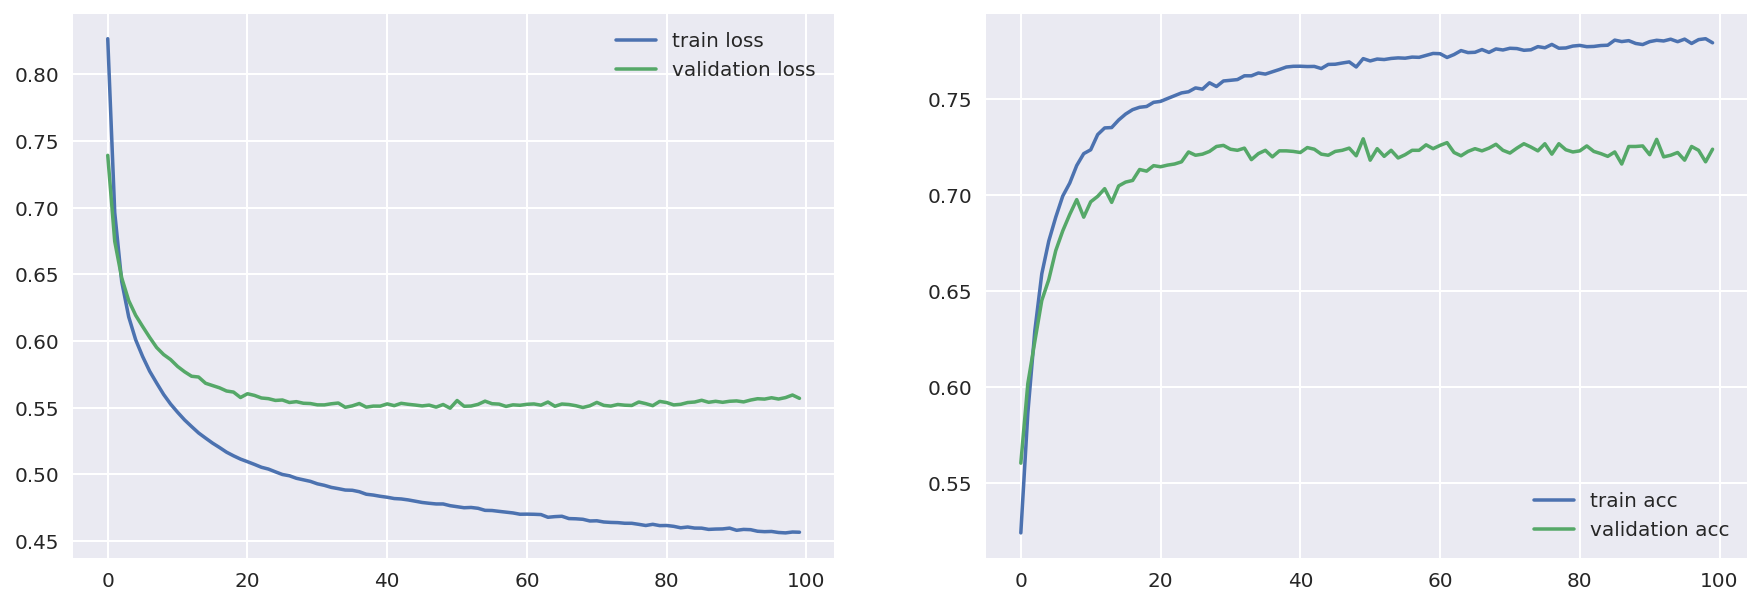

In [94]:
plot_losses(history.history['loss'], history.history['val_loss'], 
            history.history['acc'], history.history['val_acc'], 1)

In [112]:
pd.concat((results[results.Results=='train'][['ROC-AUC']].reset_index(drop=True), 
           results[results.Results=='valid'][['ROC-AUC']].reset_index(drop=True), 
           results[results.Results=='test'][['ROC-AUC', 'Description']].reset_index(drop=True)), 
           axis=1)

,ROC-AUC,ROC-AUC,ROC-AUC,Description
0,0.978668,0.782594,0.572546,CvReBnFlDeReBnDe
1,0.640677,0.637547,0.545040,CvFlDe
2,0.846924,0.814170,0.545072,CvReFlDe
3,0.854442,0.812522,0.556591,CvReBnFlDe
4,0.979215,0.772370,0.531551,CvReBnFlDeReBnDe
5,0.867871,0.798536,0.574072,FlDeReBnDe


In [113]:
def create_custom_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(9, 9, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [114]:
random_state = np.random.RandomState(seed=42)
from utils import fit_base_learner
df_train, df_val, df_test, history, model = fit_base_learner(
    X_tra, y_tra, X_val, y_val, test_fold, X_test, y_test, 
    create_custom_model, random_state, 'CvReBnFlDe128ReBnDe')

Confusion matrix:
[[11543  4219]
 [ 1386 14376]]
  Model     Fold  ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.90479  0.817273   0.83686  0.912067  0.732331  0.822199   

   Precision    Recall  Logloss          Description  
0   0.773111  0.912067  0.39819  CvReBnFlDe128ReBnDe  
Confusion matrix:
[[1201  551]
 [ 288 1464]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.834547  0.756847  0.777276  0.835616  0.685502  0.760559   

   Precision    Recall   Logloss          Description  
0   0.726551  0.835616  0.491447  CvReBnFlDe128ReBnDe  
Confusion matrix:
[[96993 43473]
 [  129   135]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.625802  0.594223  0.006154  0.511364  0.690509  0.690173   

   Precision    Recall   Logloss          Description  
0   0.003096  0.511364  0.508589  CvReBnFlDe128ReBnDe  


In [115]:
results = append_results(results, df_train, df_val, df_test)
results

,Results,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,train,CNN,Erk.csv,0.978668,0.923351,0.925128,0.944233,0.902931,0.923582,0.906781,0.944233,NaN,CvReBnFlDeReBnDe
1,valid,CNN,Erk.csv,0.782594,0.718580,0.720363,0.724886,0.712329,0.718607,0.715896,0.724886,0.944661,CvReBnFlDeReBnDe
2,test,CNN,Erk.csv,0.572546,0.543909,0.005061,0.435606,0.679139,0.678683,0.002545,0.435606,NaN,CvReBnFlDeReBnDe
3,train,CNN,Erk.csv,0.640677,0.593560,0.586381,0.575815,0.611851,0.593833,0.597341,0.575815,0.660544,CvFlDe
4,valid,CNN,Erk.csv,0.637547,0.599260,0.588615,0.572489,0.627283,0.599886,0.605676,0.572489,0.663450,CvFlDe
5,test,CNN,Erk.csv,0.545040,0.516106,0.004020,0.484848,0.549378,0.549257,0.002018,0.484848,0.750034,CvFlDe
6,train,CNN,Erk.csv,0.846924,0.762612,0.783846,0.845959,0.687476,0.766717,0.730230,0.845959,0.476779,CvReFlDe
7,valid,CNN,Erk.csv,0.814170,0.734445,0.755721,0.810502,0.665525,0.738014,0.707876,0.810502,0.518394,CvReFlDe
8,test,CNN,Erk.csv,0.545072,0.455973,0.004961,0.257576,0.807185,0.806154,0.002504,0.257576,0.500473,CvReFlDe
9,train,CNN,Erk.csv,0.854442,0.768982,0.786092,0.838409,0.705304,0.771856,0.739922,0.838409,0.467133,CvReBnFlDe


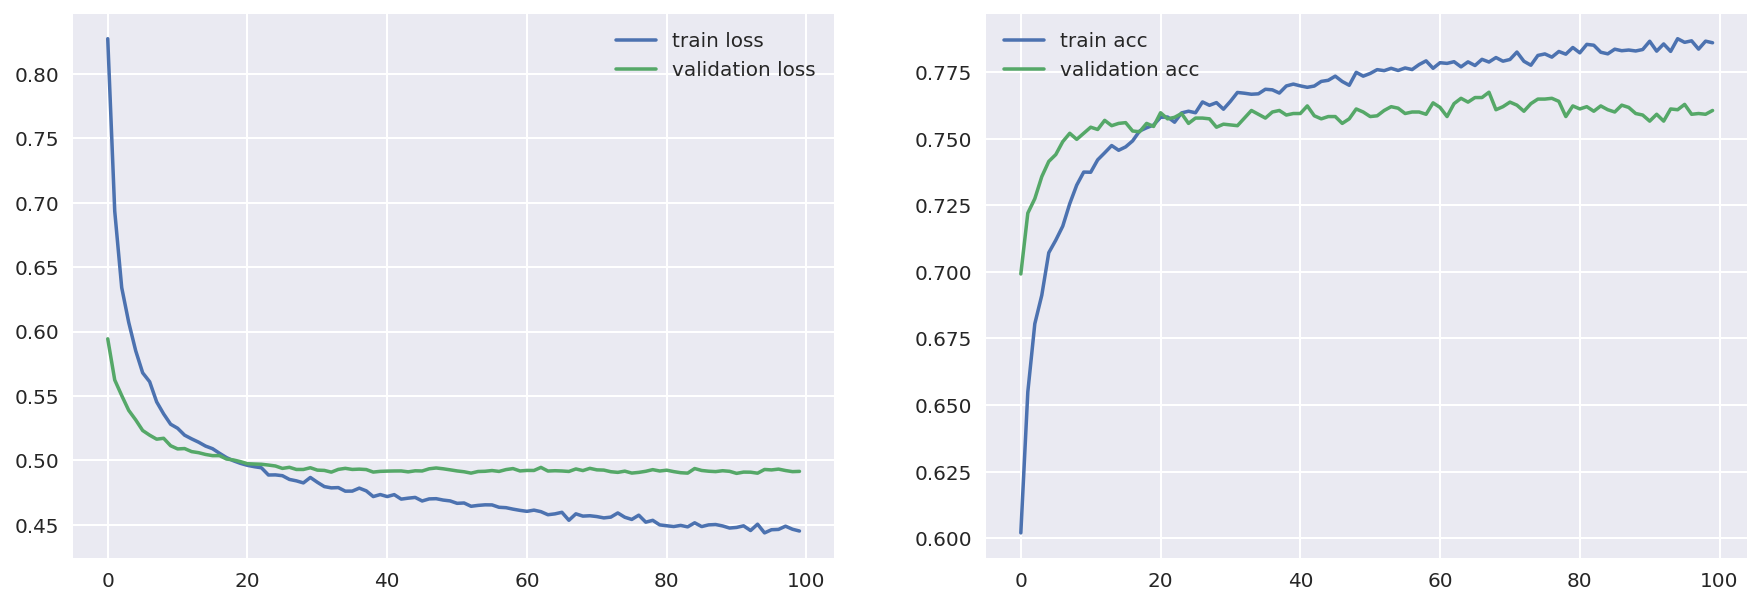

In [116]:
plot_losses(history.history['loss'], history.history['val_loss'], 
            history.history['acc'], history.history['val_acc'], 1)

In [117]:
pd.concat((results[results.Results=='train'][['G-mean']].reset_index(drop=True), 
           results[results.Results=='valid'][['G-mean']].reset_index(drop=True), 
           results[results.Results=='test'][['G-mean', 'Description']].reset_index(drop=True)), 
           axis=1)

,G-mean,G-mean,G-mean,Description
0,0.923351,0.718580,0.543909,CvReBnFlDeReBnDe
1,0.593560,0.599260,0.516106,CvFlDe
2,0.762612,0.734445,0.455973,CvReFlDe
3,0.768982,0.730695,0.488143,CvReBnFlDe
4,0.927742,0.707861,0.498057,CvReBnFlDeReBnDe
5,0.783744,0.723905,0.504932,FlDeReBnDe
6,0.817273,0.756847,0.594223,CvReBnFlDe128ReBnDe


In [118]:
def create_custom_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(9, 9, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [119]:
random_state = np.random.RandomState(seed=42)
from utils import fit_base_learner
df_train, df_val, df_test, history, model = fit_base_learner(
    X_tra, y_tra, X_val, y_val, test_fold, X_test, y_test, 
    create_custom_model, random_state, 'CvReBnDpFlDe128ReBnDpDe')

Confusion matrix:
[[11827  3935]
 [ 1646 14116]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.905393  0.819751  0.834945  0.895572  0.750349   0.82296   

   Precision    Recall   Logloss              Description  
0   0.782007  0.895572  0.393165  CvReBnDpFlDe128ReBnDpDe  
Confusion matrix:
[[1220  532]
 [ 327 1425]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.833141  0.752581  0.768401  0.813356  0.696347  0.754852   

   Precision    Recall   Logloss              Description  
0   0.728155  0.813356  0.497724  CvReBnDpFlDe128ReBnDpDe  
Confusion matrix:
[[105043  35423]
 [   142    122]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.617517  0.587863  0.006814  0.462121  0.747818  0.747282   

   Precision    Recall  Logloss              Description  
0   0.003432  0.462121  0.46547  CvReBnDpFlDe128ReBnDpDe  


In [120]:
results = append_results(results, df_train, df_val, df_test)
results

,Results,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,train,CNN,Erk.csv,0.978668,0.923351,0.925128,0.944233,0.902931,0.923582,0.906781,0.944233,NaN,CvReBnFlDeReBnDe
1,valid,CNN,Erk.csv,0.782594,0.718580,0.720363,0.724886,0.712329,0.718607,0.715896,0.724886,0.944661,CvReBnFlDeReBnDe
2,test,CNN,Erk.csv,0.572546,0.543909,0.005061,0.435606,0.679139,0.678683,0.002545,0.435606,NaN,CvReBnFlDeReBnDe
3,train,CNN,Erk.csv,0.640677,0.593560,0.586381,0.575815,0.611851,0.593833,0.597341,0.575815,0.660544,CvFlDe
4,valid,CNN,Erk.csv,0.637547,0.599260,0.588615,0.572489,0.627283,0.599886,0.605676,0.572489,0.663450,CvFlDe
5,test,CNN,Erk.csv,0.545040,0.516106,0.004020,0.484848,0.549378,0.549257,0.002018,0.484848,0.750034,CvFlDe
6,train,CNN,Erk.csv,0.846924,0.762612,0.783846,0.845959,0.687476,0.766717,0.730230,0.845959,0.476779,CvReFlDe
7,valid,CNN,Erk.csv,0.814170,0.734445,0.755721,0.810502,0.665525,0.738014,0.707876,0.810502,0.518394,CvReFlDe
8,test,CNN,Erk.csv,0.545072,0.455973,0.004961,0.257576,0.807185,0.806154,0.002504,0.257576,0.500473,CvReFlDe
9,train,CNN,Erk.csv,0.854442,0.768982,0.786092,0.838409,0.705304,0.771856,0.739922,0.838409,0.467133,CvReBnFlDe


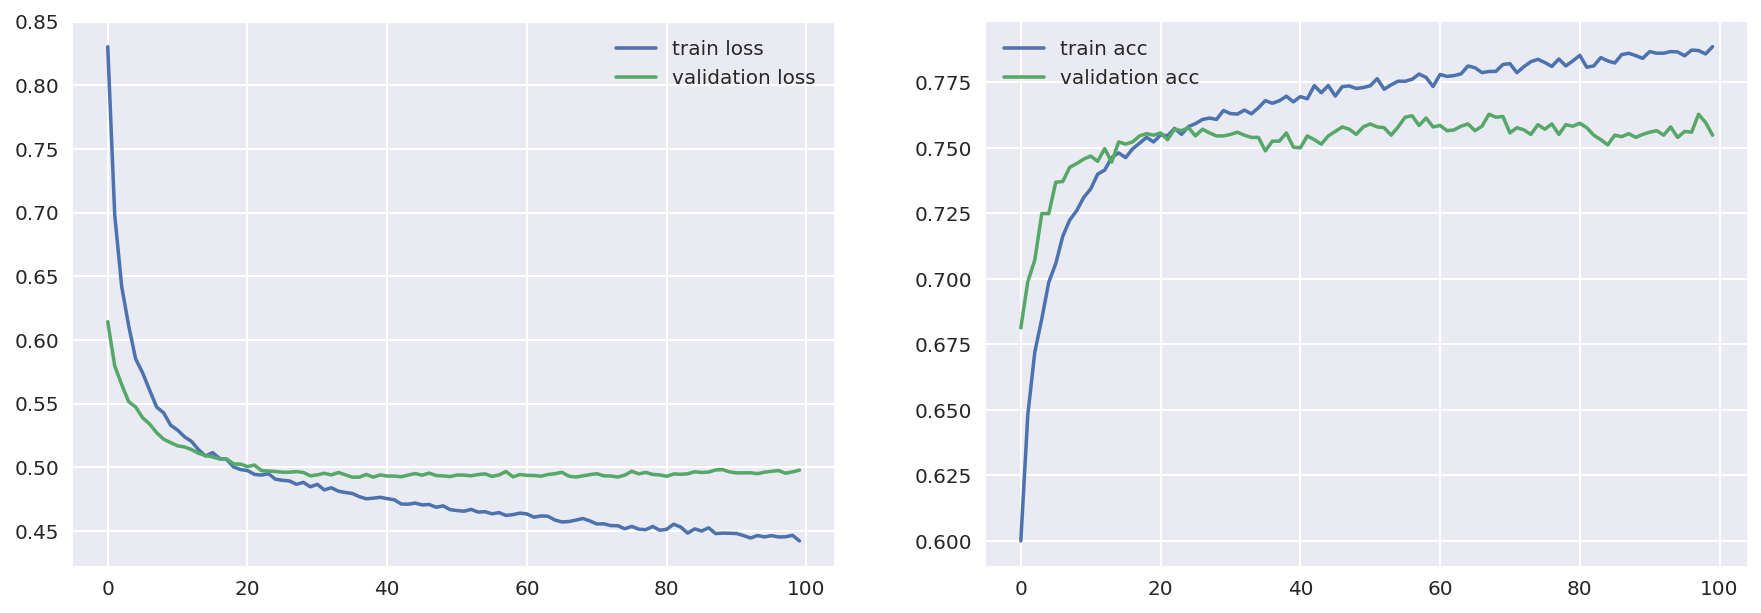

In [121]:
plot_losses(history.history['loss'], history.history['val_loss'], 
            history.history['acc'], history.history['val_acc'], 1)

In [122]:
pd.concat((results[results.Results=='train'][['G-mean']].reset_index(drop=True), 
           results[results.Results=='valid'][['G-mean']].reset_index(drop=True), 
           results[results.Results=='test'][['G-mean', 'Description']].reset_index(drop=True)), 
           axis=1)

,G-mean,G-mean,G-mean,Description
0,0.923351,0.718580,0.543909,CvReBnFlDeReBnDe
1,0.593560,0.599260,0.516106,CvFlDe
2,0.762612,0.734445,0.455973,CvReFlDe
3,0.768982,0.730695,0.488143,CvReBnFlDe
4,0.927742,0.707861,0.498057,CvReBnFlDeReBnDe
5,0.783744,0.723905,0.504932,FlDeReBnDe
6,0.817273,0.756847,0.594223,CvReBnFlDe128ReBnDe
7,0.819751,0.752581,0.587863,CvReBnDpFlDe128ReBnDpDe


In [123]:
def create_custom_model():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(9, 9, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, (3, 3), strides=2))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [125]:
random_state = np.random.RandomState(seed=42)
from utils import fit_base_learner
df_train, df_val, df_test, history, model = fit_base_learner(
    X_tra, y_tra, X_val, y_val, test_fold, X_test, y_test, 
    create_custom_model, random_state, 'Cv64ReBnDp-Cv128ReBnDp-FlDe128ReBnDpDe')

Confusion matrix:
[[11906  3856]
 [ 1443 14319]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.913307  0.828377  0.843858  0.908451  0.755361  0.831906   

   Precision    Recall   Logloss                             Description  
0    0.78784  0.908451  0.373161  Cv64ReBnDp-Cv128ReBnDp-FlDe128ReBnDpDe  
Confusion matrix:
[[1229  523]
 [ 295 1457]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.836196  0.763786  0.780815  0.831621  0.701484  0.766553   

   Precision    Recall   Logloss                             Description  
0   0.735859  0.831621  0.498239  Cv64ReBnDp-Cv128ReBnDp-FlDe128ReBnDpDe  
Confusion matrix:
[[100075  40391]
 [   132    132]]
  Model     Fold   ROC-AUC    G-mean  F1-Score  TPR      TNR  Accuracy  \
0   CNN  Erk.csv  0.623161  0.596846  0.006473  0.5  0.71245  0.712051   

   Precision  Recall  Logloss                             Description  
0   0.0032

In [126]:
results = append_results(results, df_train, df_val, df_test)
results

,Results,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,train,CNN,Erk.csv,0.978668,0.923351,0.925128,0.944233,0.902931,0.923582,0.906781,0.944233,NaN,CvReBnFlDeReBnDe
1,valid,CNN,Erk.csv,0.782594,0.718580,0.720363,0.724886,0.712329,0.718607,0.715896,0.724886,0.944661,CvReBnFlDeReBnDe
2,test,CNN,Erk.csv,0.572546,0.543909,0.005061,0.435606,0.679139,0.678683,0.002545,0.435606,NaN,CvReBnFlDeReBnDe
3,train,CNN,Erk.csv,0.640677,0.593560,0.586381,0.575815,0.611851,0.593833,0.597341,0.575815,0.660544,CvFlDe
4,valid,CNN,Erk.csv,0.637547,0.599260,0.588615,0.572489,0.627283,0.599886,0.605676,0.572489,0.663450,CvFlDe
5,test,CNN,Erk.csv,0.545040,0.516106,0.004020,0.484848,0.549378,0.549257,0.002018,0.484848,0.750034,CvFlDe
6,train,CNN,Erk.csv,0.846924,0.762612,0.783846,0.845959,0.687476,0.766717,0.730230,0.845959,0.476779,CvReFlDe
7,valid,CNN,Erk.csv,0.814170,0.734445,0.755721,0.810502,0.665525,0.738014,0.707876,0.810502,0.518394,CvReFlDe
8,test,CNN,Erk.csv,0.545072,0.455973,0.004961,0.257576,0.807185,0.806154,0.002504,0.257576,0.500473,CvReFlDe
9,train,CNN,Erk.csv,0.854442,0.768982,0.786092,0.838409,0.705304,0.771856,0.739922,0.838409,0.467133,CvReBnFlDe


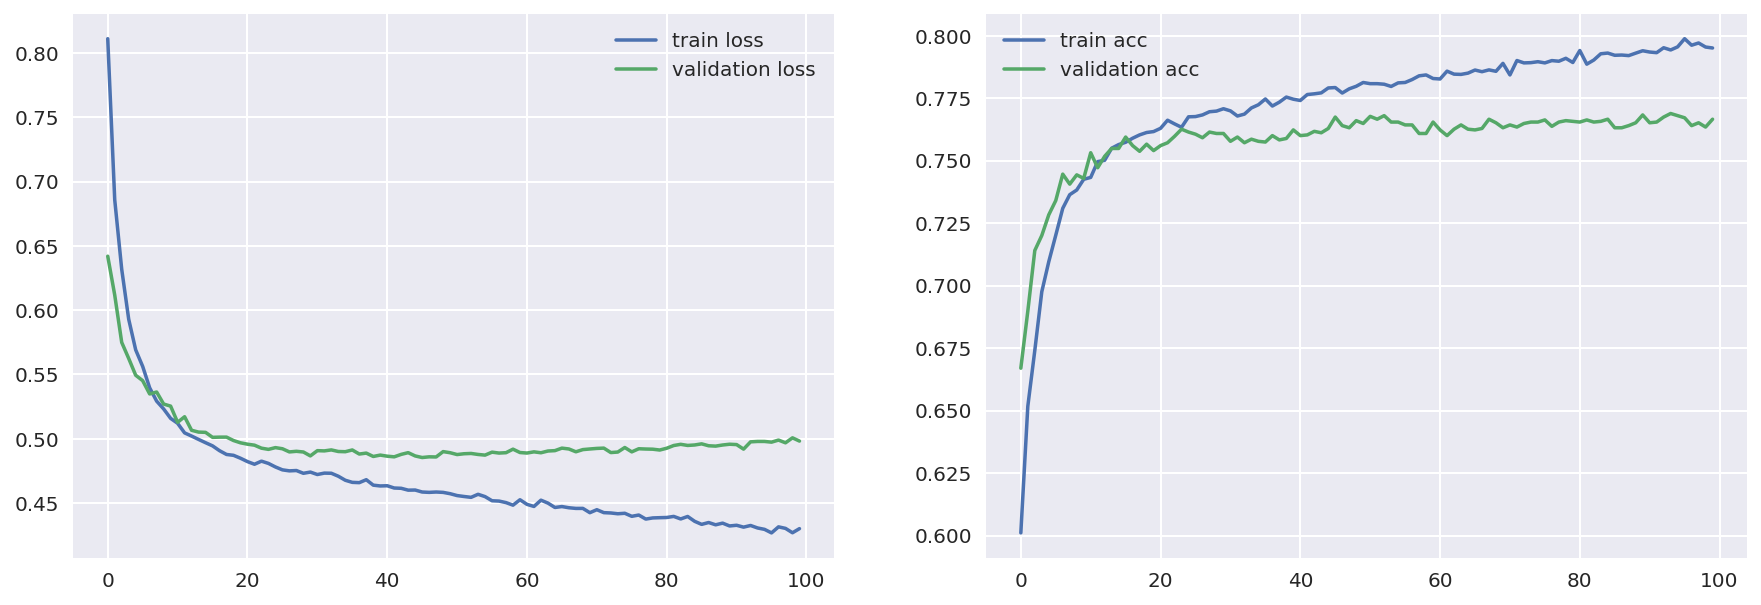

In [127]:
plot_losses(history.history['loss'], history.history['val_loss'], 
            history.history['acc'], history.history['val_acc'], 1)

In [132]:
pd.concat((results[results.Results=='train'][['G-mean']].reset_index(drop=True), 
           results[results.Results=='valid'][['G-mean']].reset_index(drop=True), 
           results[results.Results=='test'][['G-mean', 'TPR', 'TNR', 'Description']].reset_index(drop=True)), 
           axis=1)

,G-mean,G-mean,G-mean,TPR,TNR,Description
0,0.923351,0.718580,0.543909,0.435606,0.679139,CvReBnFlDeReBnDe
1,0.593560,0.599260,0.516106,0.484848,0.549378,CvFlDe
2,0.762612,0.734445,0.455973,0.257576,0.807185,CvReFlDe
3,0.768982,0.730695,0.488143,0.291667,0.816974,CvReBnFlDe
4,0.927742,0.707861,0.498057,0.344697,0.719647,CvReBnFlDeReBnDe
5,0.783744,0.723905,0.504932,0.333333,0.764868,FlDeReBnDe
6,0.817273,0.756847,0.594223,0.511364,0.690509,CvReBnFlDe128ReBnDe
7,0.819751,0.752581,0.587863,0.462121,0.747818,CvReBnDpFlDe128ReBnDpDe
8,0.828377,0.763786,0.596846,0.500000,0.712450,Cv64ReBnDp-Cv128ReBnDp-FlDe128ReBnDpDe


In [133]:
def create_custom_model():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(9, 9, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, (3, 3), strides=2))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [135]:
random_state = np.random.RandomState(seed=42)
from utils import fit_base_learner
df_train, df_val, df_test, history, model = fit_base_learner(
    X_tra, y_tra, X_val, y_val, test_fold, X_test, y_test, 
    create_custom_model, random_state, '3xCv256ReBnDp-2xFlDe256ReBnDpDe')

Confusion matrix:
[[10784  4978]
 [  988 14774]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.903307  0.800807   0.83201  0.937318  0.684177  0.810747   

   Precision    Recall   Logloss                      Description  
0   0.747975  0.937318  0.389002  3xCv256ReBnDp-2xFlDe256ReBnDpDe  
Confusion matrix:
[[1127  625]
 [ 216 1536]]
  Model     Fold  ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.83683  0.750972  0.785075  0.876712  0.643265  0.759989   

   Precision    Recall   Logloss                      Description  
0   0.710782  0.876712  0.502696  3xCv256ReBnDp-2xFlDe256ReBnDpDe  
Confusion matrix:
[[82787 57679]
 [   98   166]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.630938  0.608762  0.005713  0.628788  0.589374  0.589448   

   Precision    Recall   Logloss                      Description  
0    0.00287  0.628788  0.641216  3x

In [136]:
results = append_results(results, df_train, df_val, df_test)
results

,Results,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,train,CNN,Erk.csv,0.978668,0.923351,0.925128,0.944233,0.902931,0.923582,0.906781,0.944233,NaN,CvReBnFlDeReBnDe
1,valid,CNN,Erk.csv,0.782594,0.718580,0.720363,0.724886,0.712329,0.718607,0.715896,0.724886,0.944661,CvReBnFlDeReBnDe
2,test,CNN,Erk.csv,0.572546,0.543909,0.005061,0.435606,0.679139,0.678683,0.002545,0.435606,NaN,CvReBnFlDeReBnDe
3,train,CNN,Erk.csv,0.640677,0.593560,0.586381,0.575815,0.611851,0.593833,0.597341,0.575815,0.660544,CvFlDe
4,valid,CNN,Erk.csv,0.637547,0.599260,0.588615,0.572489,0.627283,0.599886,0.605676,0.572489,0.663450,CvFlDe
5,test,CNN,Erk.csv,0.545040,0.516106,0.004020,0.484848,0.549378,0.549257,0.002018,0.484848,0.750034,CvFlDe
6,train,CNN,Erk.csv,0.846924,0.762612,0.783846,0.845959,0.687476,0.766717,0.730230,0.845959,0.476779,CvReFlDe
7,valid,CNN,Erk.csv,0.814170,0.734445,0.755721,0.810502,0.665525,0.738014,0.707876,0.810502,0.518394,CvReFlDe
8,test,CNN,Erk.csv,0.545072,0.455973,0.004961,0.257576,0.807185,0.806154,0.002504,0.257576,0.500473,CvReFlDe
9,train,CNN,Erk.csv,0.854442,0.768982,0.786092,0.838409,0.705304,0.771856,0.739922,0.838409,0.467133,CvReBnFlDe


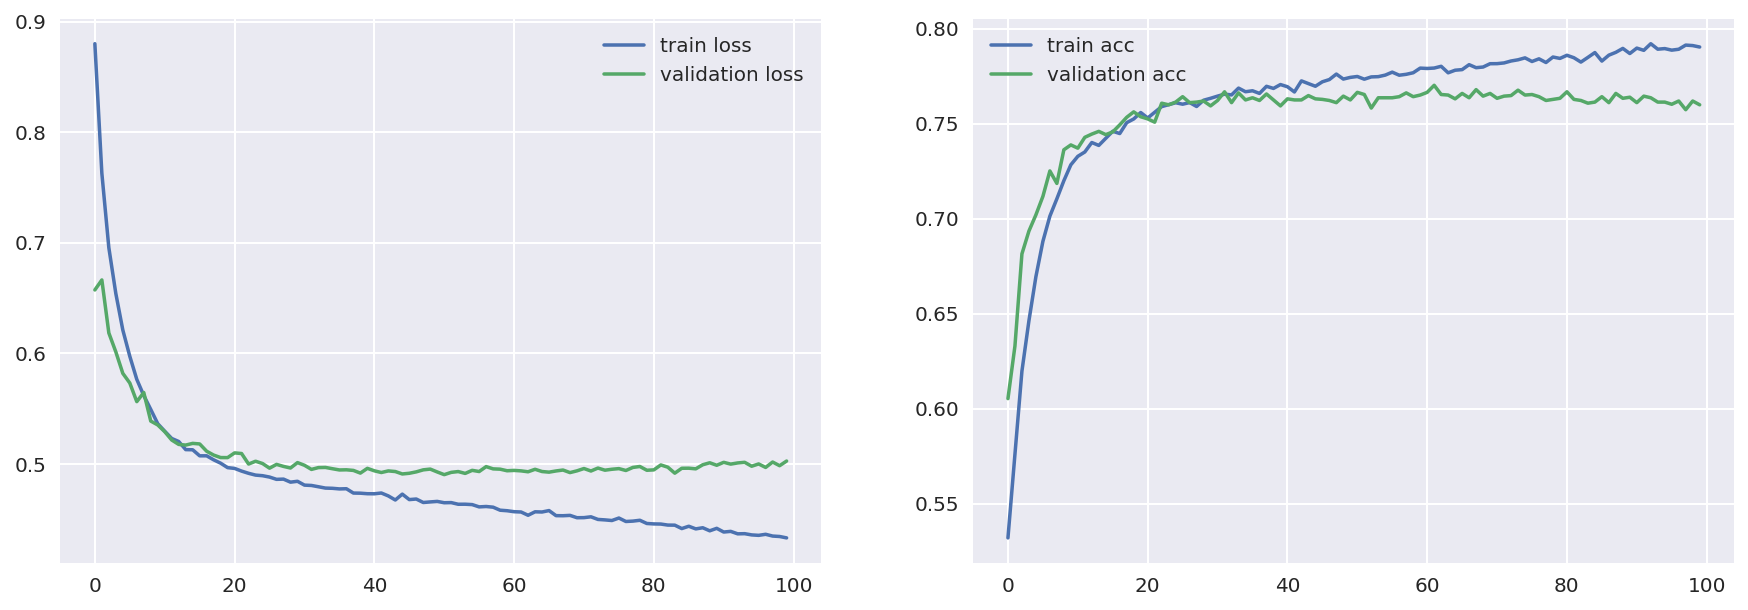

In [138]:
plot_losses(history.history['loss'], history.history['val_loss'], 
            history.history['acc'], history.history['val_acc'], 1)

In [137]:
pd.concat((results[results.Results=='train'][['G-mean']].reset_index(drop=True), 
           results[results.Results=='valid'][['G-mean']].reset_index(drop=True), 
           results[results.Results=='test'][['G-mean', 'TPR', 'TNR', 'Description']].reset_index(drop=True)), 
           axis=1)

,G-mean,G-mean,G-mean,TPR,TNR,Description
0,0.923351,0.718580,0.543909,0.435606,0.679139,CvReBnFlDeReBnDe
1,0.593560,0.599260,0.516106,0.484848,0.549378,CvFlDe
2,0.762612,0.734445,0.455973,0.257576,0.807185,CvReFlDe
3,0.768982,0.730695,0.488143,0.291667,0.816974,CvReBnFlDe
4,0.927742,0.707861,0.498057,0.344697,0.719647,CvReBnFlDeReBnDe
5,0.783744,0.723905,0.504932,0.333333,0.764868,FlDeReBnDe
6,0.817273,0.756847,0.594223,0.511364,0.690509,CvReBnFlDe128ReBnDe
7,0.819751,0.752581,0.587863,0.462121,0.747818,CvReBnDpFlDe128ReBnDpDe
8,0.828377,0.763786,0.596846,0.500000,0.712450,Cv64ReBnDp-Cv128ReBnDp-FlDe128ReBnDpDe
9,0.800807,0.750972,0.608762,0.628788,0.589374,3xCv256ReBnDp-2xFlDe256ReBnDpDe


In [139]:
def create_custom_model():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(9, 9, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [140]:
create_custom_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 9, 9, 64)          640       
_________________________________________________________________
activation_44 (Activation)   (None, 9, 9, 64)          0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 9, 9, 64)          256       
_________________________________________________________________
dropout_31 (Dropout)         (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
activation_45 (Activation)   (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 7, 7, 128)         512       
__________

In [141]:
random_state = np.random.RandomState(seed=42)
from utils import fit_base_learner
df_train, df_val, df_test, history, model = fit_base_learner(
    X_tra, y_tra, X_val, y_val, test_fold, X_test, y_test, 
    create_custom_model, random_state, '3xCv256ReBnDp-2xFlDe256ReBnDpDe')

Confusion matrix:
[[10876  4886]
 [ 1064 14698]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.898633  0.802144  0.831664  0.932496  0.690014  0.811255   

   Precision    Recall   Logloss                      Description  
0   0.750511  0.932496  0.390848  3xCv256ReBnDp-2xFlDe256ReBnDpDe  
Confusion matrix:
[[1136  616]
 [ 212 1540]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.838179  0.754945  0.788127  0.878995  0.648402  0.763699   

   Precision    Recall   Logloss                      Description  
0   0.714286  0.878995  0.503119  3xCv256ReBnDp-2xFlDe256ReBnDpDe  
Confusion matrix:
[[84875 55591]
 [  108   156]]
  Model     Fold  ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.62515  0.597537   0.00557  0.590909  0.604239  0.604214   

   Precision    Recall   Logloss                      Description  
0   0.002798  0.590909  0.599678  3x

In [142]:
results = append_results(results, df_train, df_val, df_test)
results

,Results,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,train,CNN,Erk.csv,0.978668,0.923351,0.925128,0.944233,0.902931,0.923582,0.906781,0.944233,NaN,CvReBnFlDeReBnDe
1,valid,CNN,Erk.csv,0.782594,0.718580,0.720363,0.724886,0.712329,0.718607,0.715896,0.724886,0.944661,CvReBnFlDeReBnDe
2,test,CNN,Erk.csv,0.572546,0.543909,0.005061,0.435606,0.679139,0.678683,0.002545,0.435606,NaN,CvReBnFlDeReBnDe
3,train,CNN,Erk.csv,0.640677,0.593560,0.586381,0.575815,0.611851,0.593833,0.597341,0.575815,0.660544,CvFlDe
4,valid,CNN,Erk.csv,0.637547,0.599260,0.588615,0.572489,0.627283,0.599886,0.605676,0.572489,0.663450,CvFlDe
5,test,CNN,Erk.csv,0.545040,0.516106,0.004020,0.484848,0.549378,0.549257,0.002018,0.484848,0.750034,CvFlDe
6,train,CNN,Erk.csv,0.846924,0.762612,0.783846,0.845959,0.687476,0.766717,0.730230,0.845959,0.476779,CvReFlDe
7,valid,CNN,Erk.csv,0.814170,0.734445,0.755721,0.810502,0.665525,0.738014,0.707876,0.810502,0.518394,CvReFlDe
8,test,CNN,Erk.csv,0.545072,0.455973,0.004961,0.257576,0.807185,0.806154,0.002504,0.257576,0.500473,CvReFlDe
9,train,CNN,Erk.csv,0.854442,0.768982,0.786092,0.838409,0.705304,0.771856,0.739922,0.838409,0.467133,CvReBnFlDe


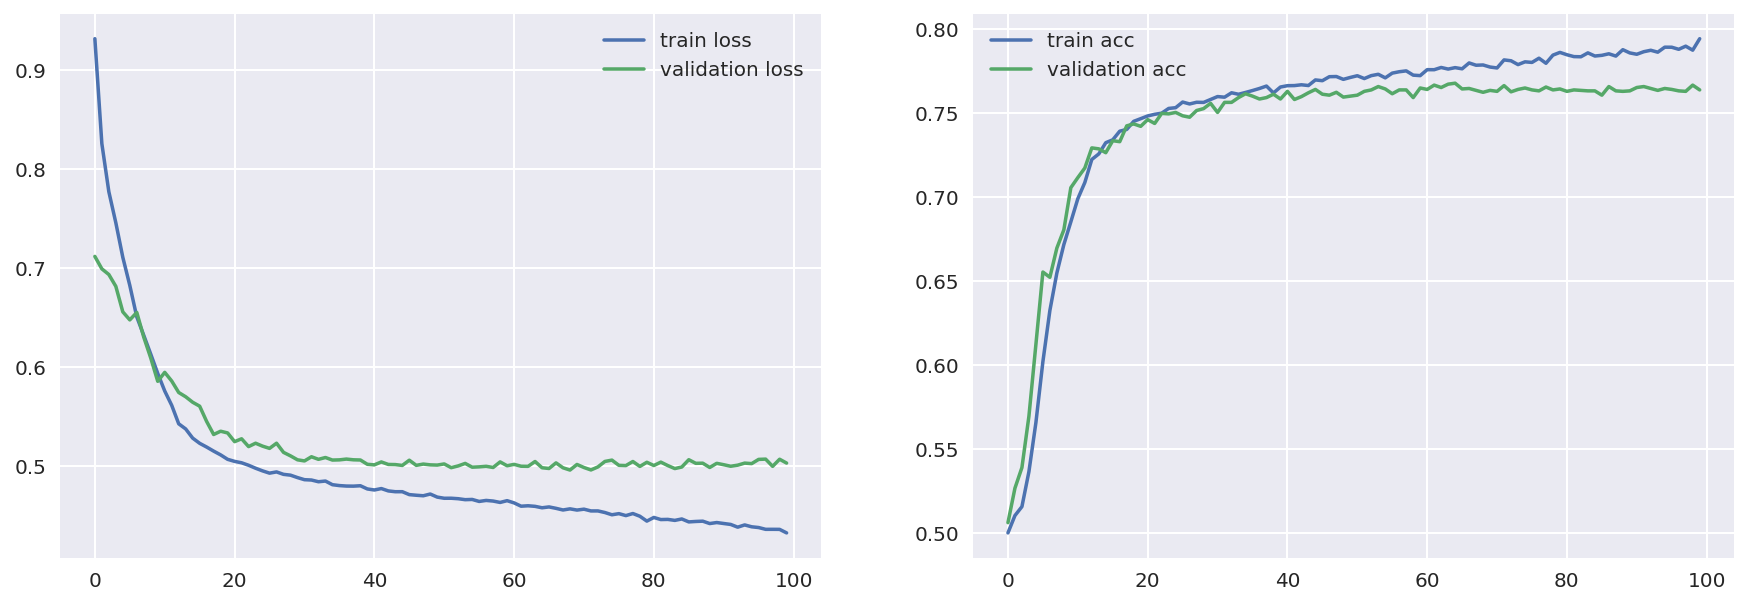

In [143]:
plot_losses(history.history['loss'], history.history['val_loss'], 
            history.history['acc'], history.history['val_acc'], 1)

In [146]:
pd.concat((results[results.Results=='train'][['G-mean']].reset_index(drop=True), 
           results[results.Results=='valid'][['G-mean']].reset_index(drop=True), 
           results[results.Results=='test'][['G-mean', 'TPR', 'TNR', 'Description']].reset_index(drop=True)), 
           axis=1)

,G-mean,G-mean,G-mean,TPR,TNR,Description
0,0.923351,0.718580,0.543909,0.435606,0.679139,CvReBnFlDeReBnDe
1,0.593560,0.599260,0.516106,0.484848,0.549378,CvFlDe
2,0.762612,0.734445,0.455973,0.257576,0.807185,CvReFlDe
3,0.768982,0.730695,0.488143,0.291667,0.816974,CvReBnFlDe
4,0.927742,0.707861,0.498057,0.344697,0.719647,CvReBnFlDeReBnDe
5,0.783744,0.723905,0.504932,0.333333,0.764868,FlDeReBnDe
6,0.817273,0.756847,0.594223,0.511364,0.690509,CvReBnFlDe128ReBnDe
7,0.819751,0.752581,0.587863,0.462121,0.747818,CvReBnDpFlDe128ReBnDpDe
8,0.828377,0.763786,0.596846,0.500000,0.712450,Cv64ReBnDp-Cv128ReBnDp-FlDe128ReBnDpDe
9,0.800807,0.750972,0.608762,0.628788,0.589374,3xCv256ReBnDp-2xFlDe256ReBnDpDe


In [144]:
def create_custom_model():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(9, 9, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [145]:
random_state = np.random.RandomState(seed=42)
from utils import fit_base_learner
df_train, df_val, df_test, history, model = fit_base_learner(
    X_tra, y_tra, X_val, y_val, test_fold, X_test, y_test, 
    create_custom_model, random_state, '3xCv256ReBnDp-2xFlDe256ReBnDpDe')

Confusion matrix:
[[11112  4650]
 [  854 14908]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.913886  0.816572  0.844168  0.945819  0.704987  0.825403   

   Precision    Recall   Logloss                      Description  
0   0.762246  0.945819  0.367231  3xCv256ReBnDp-2xFlDe256ReBnDpDe  
Confusion matrix:
[[1138  614]
 [ 215 1537]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.831596  0.754873  0.787599  0.877283  0.649543  0.763413   

   Precision    Recall   Logloss                      Description  
0   0.714551  0.877283  0.520678  3xCv256ReBnDp-2xFlDe256ReBnDpDe  
Confusion matrix:
[[86901 53565]
 [  110   154]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.625185  0.600738  0.005705  0.583333  0.618662  0.618596   

   Precision    Recall   Logloss                      Description  
0   0.002867  0.583333  0.615261  

In [147]:
results

,Results,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,train,CNN,Erk.csv,0.978668,0.923351,0.925128,0.944233,0.902931,0.923582,0.906781,0.944233,NaN,CvReBnFlDeReBnDe
1,valid,CNN,Erk.csv,0.782594,0.718580,0.720363,0.724886,0.712329,0.718607,0.715896,0.724886,0.944661,CvReBnFlDeReBnDe
2,test,CNN,Erk.csv,0.572546,0.543909,0.005061,0.435606,0.679139,0.678683,0.002545,0.435606,NaN,CvReBnFlDeReBnDe
3,train,CNN,Erk.csv,0.640677,0.593560,0.586381,0.575815,0.611851,0.593833,0.597341,0.575815,0.660544,CvFlDe
4,valid,CNN,Erk.csv,0.637547,0.599260,0.588615,0.572489,0.627283,0.599886,0.605676,0.572489,0.663450,CvFlDe
5,test,CNN,Erk.csv,0.545040,0.516106,0.004020,0.484848,0.549378,0.549257,0.002018,0.484848,0.750034,CvFlDe
6,train,CNN,Erk.csv,0.846924,0.762612,0.783846,0.845959,0.687476,0.766717,0.730230,0.845959,0.476779,CvReFlDe
7,valid,CNN,Erk.csv,0.814170,0.734445,0.755721,0.810502,0.665525,0.738014,0.707876,0.810502,0.518394,CvReFlDe
8,test,CNN,Erk.csv,0.545072,0.455973,0.004961,0.257576,0.807185,0.806154,0.002504,0.257576,0.500473,CvReFlDe
9,train,CNN,Erk.csv,0.854442,0.768982,0.786092,0.838409,0.705304,0.771856,0.739922,0.838409,0.467133,CvReBnFlDe


In [ ]:
results = append_results(results, df_train, df_val, df_test)
results

In [148]:
pd.concat((results[results.Results=='train'][['G-mean']].reset_index(drop=True), 
           results[results.Results=='valid'][['G-mean']].reset_index(drop=True), 
           results[results.Results=='test'][['G-mean', 'TPR', 'TNR', 'Description']].reset_index(drop=True)), 
           axis=1)

,G-mean,G-mean,G-mean,TPR,TNR,Description
0,0.923351,0.718580,0.543909,0.435606,0.679139,CvReBnFlDeReBnDe
1,0.593560,0.599260,0.516106,0.484848,0.549378,CvFlDe
2,0.762612,0.734445,0.455973,0.257576,0.807185,CvReFlDe
3,0.768982,0.730695,0.488143,0.291667,0.816974,CvReBnFlDe
4,0.927742,0.707861,0.498057,0.344697,0.719647,CvReBnFlDeReBnDe
5,0.783744,0.723905,0.504932,0.333333,0.764868,FlDeReBnDe
6,0.817273,0.756847,0.594223,0.511364,0.690509,CvReBnFlDe128ReBnDe
7,0.819751,0.752581,0.587863,0.462121,0.747818,CvReBnDpFlDe128ReBnDpDe
8,0.828377,0.763786,0.596846,0.500000,0.712450,Cv64ReBnDp-Cv128ReBnDp-FlDe128ReBnDpDe
9,0.800807,0.750972,0.608762,0.628788,0.589374,3xCv256ReBnDp-2xFlDe256ReBnDpDe


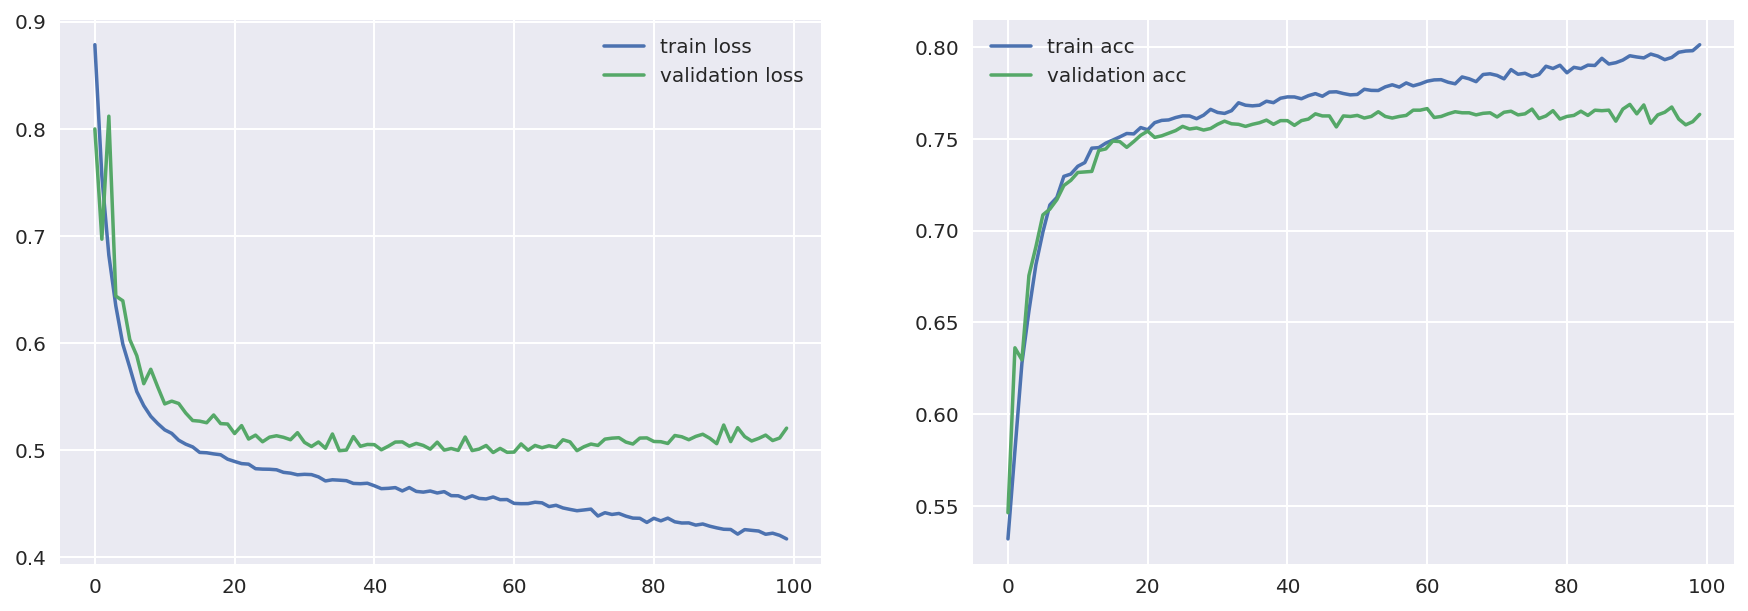

In [149]:
plot_losses(history.history['loss'], history.history['val_loss'], 
            history.history['acc'], history.history['val_acc'], 1)

In [172]:
def create_custom_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(9, 9, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Conv2D(64, (3, 3)))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [174]:
random_state = np.random.RandomState(seed=42)
from utils import fit_base_learner
df_train, df_val, df_test, history, model = fit_base_learner(
    X_tra, y_tra, X_val, y_val, test_fold, X_test, y_test, 
    create_custom_model, random_state, '2x64CvReMp-FlDe64ReDpDe')

Confusion matrix:
[[12212  3550]
 [  988 14774]]
  Model     Fold   ROC-AUC   G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.937049  0.85218  0.866866  0.937318  0.774775  0.856046   

   Precision    Recall   Logloss              Description  
0   0.806265  0.937318  0.321175  2x64CvReMp-FlDe64ReDpDe  
Confusion matrix:
[[1141  611]
 [ 354 1398]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.801023  0.720879  0.743419  0.797945  0.651256    0.7246   

   Precision    Recall   Logloss              Description  
0   0.695869  0.797945  0.624388  2x64CvReMp-FlDe64ReDpDe  
Confusion matrix:
[[78834 61632]
 [  112   152]]
  Model     Fold   ROC-AUC    G-mean  F1-Score       TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.582387  0.568448  0.004899  0.575758  0.561232  0.561259   

   Precision    Recall   Logloss              Description  
0    0.00246  0.575758  1.042045  2x64CvReMp-FlDe64ReDpDe  


In [175]:
results = append_results(results, df_train, df_val, df_test)
results

,Results,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,train,CNN,Erk.csv,0.978668,0.923351,0.925128,0.944233,0.902931,0.923582,0.906781,0.944233,NaN,CvReBnFlDeReBnDe
1,valid,CNN,Erk.csv,0.782594,0.718580,0.720363,0.724886,0.712329,0.718607,0.715896,0.724886,0.944661,CvReBnFlDeReBnDe
2,test,CNN,Erk.csv,0.572546,0.543909,0.005061,0.435606,0.679139,0.678683,0.002545,0.435606,NaN,CvReBnFlDeReBnDe
3,train,CNN,Erk.csv,0.640677,0.593560,0.586381,0.575815,0.611851,0.593833,0.597341,0.575815,0.660544,CvFlDe
4,valid,CNN,Erk.csv,0.637547,0.599260,0.588615,0.572489,0.627283,0.599886,0.605676,0.572489,0.663450,CvFlDe
5,test,CNN,Erk.csv,0.545040,0.516106,0.004020,0.484848,0.549378,0.549257,0.002018,0.484848,0.750034,CvFlDe
6,train,CNN,Erk.csv,0.846924,0.762612,0.783846,0.845959,0.687476,0.766717,0.730230,0.845959,0.476779,CvReFlDe
7,valid,CNN,Erk.csv,0.814170,0.734445,0.755721,0.810502,0.665525,0.738014,0.707876,0.810502,0.518394,CvReFlDe
8,test,CNN,Erk.csv,0.545072,0.455973,0.004961,0.257576,0.807185,0.806154,0.002504,0.257576,0.500473,CvReFlDe
9,train,CNN,Erk.csv,0.854442,0.768982,0.786092,0.838409,0.705304,0.771856,0.739922,0.838409,0.467133,CvReBnFlDe


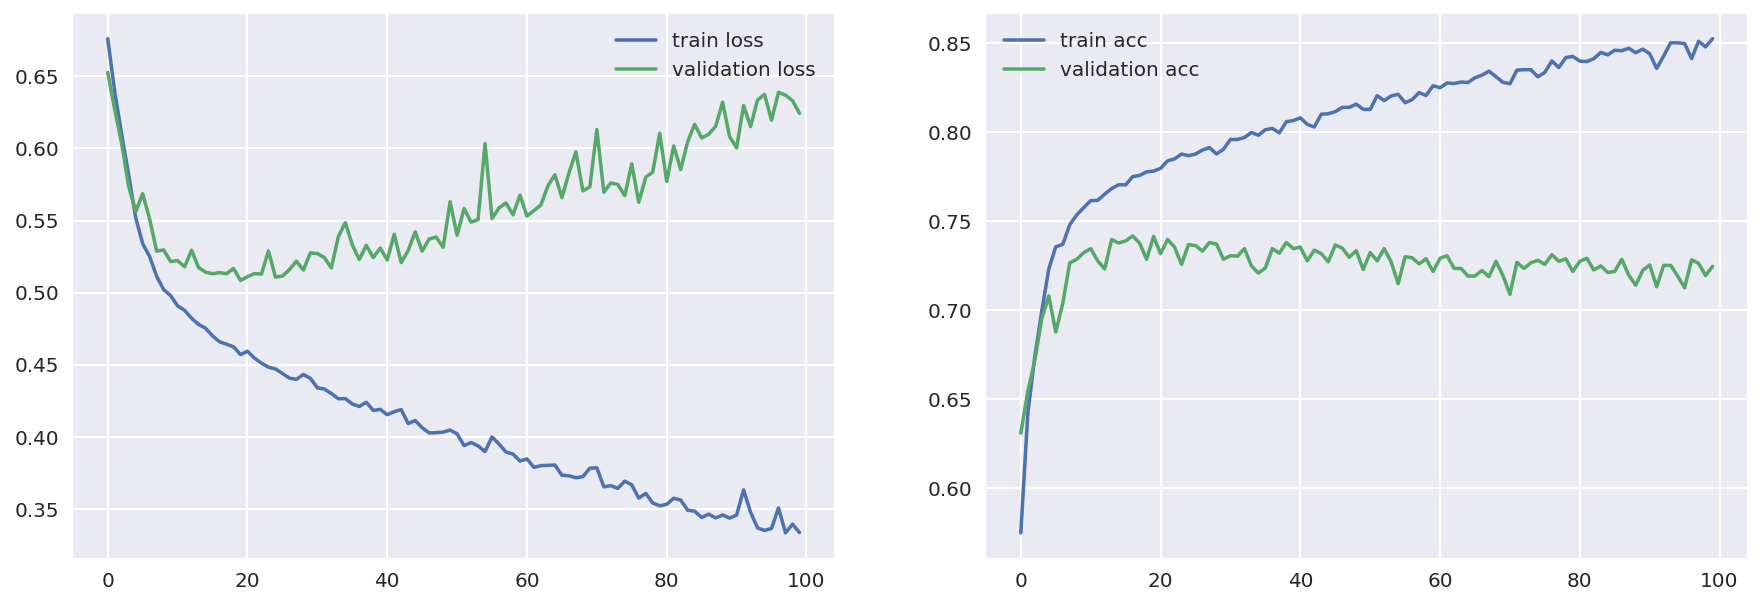

In [176]:
plot_losses(history.history['loss'], history.history['val_loss'], 
            history.history['acc'], history.history['val_acc'], 1)

In [177]:
pd.concat((results[results.Results=='train'][['G-mean']].reset_index(drop=True), 
           results[results.Results=='valid'][['G-mean']].reset_index(drop=True), 
           results[results.Results=='test'][['G-mean', 'TPR', 'TNR', 'Description']].reset_index(drop=True)), 
           axis=1)

,G-mean,G-mean,G-mean,TPR,TNR,Description
0,0.923351,0.718580,0.543909,0.435606,0.679139,CvReBnFlDeReBnDe
1,0.593560,0.599260,0.516106,0.484848,0.549378,CvFlDe
2,0.762612,0.734445,0.455973,0.257576,0.807185,CvReFlDe
3,0.768982,0.730695,0.488143,0.291667,0.816974,CvReBnFlDe
4,0.927742,0.707861,0.498057,0.344697,0.719647,CvReBnFlDeReBnDe
5,0.783744,0.723905,0.504932,0.333333,0.764868,FlDeReBnDe
6,0.817273,0.756847,0.594223,0.511364,0.690509,CvReBnFlDe128ReBnDe
7,0.819751,0.752581,0.587863,0.462121,0.747818,CvReBnDpFlDe128ReBnDpDe
8,0.828377,0.763786,0.596846,0.500000,0.712450,Cv64ReBnDp-Cv128ReBnDp-FlDe128ReBnDpDe
9,0.800807,0.750972,0.608762,0.628788,0.589374,3xCv256ReBnDp-2xFlDe256ReBnDpDe


In [179]:
pd.concat((results[results.Results=='train'][['ROC-AUC']].reset_index(drop=True), 
           results[results.Results=='valid'][['ROC-AUC']].reset_index(drop=True), 
           results[results.Results=='test'][['ROC-AUC', 'TPR', 'TNR', 'Description']].reset_index(drop=True)), 
           axis=1)

,ROC-AUC,ROC-AUC,ROC-AUC,TPR,TNR,Description
0,0.978668,0.782594,0.572546,0.435606,0.679139,CvReBnFlDeReBnDe
1,0.640677,0.637547,0.545040,0.484848,0.549378,CvFlDe
2,0.846924,0.814170,0.545072,0.257576,0.807185,CvReFlDe
3,0.854442,0.812522,0.556591,0.291667,0.816974,CvReBnFlDe
4,0.979215,0.772370,0.531551,0.344697,0.719647,CvReBnFlDeReBnDe
5,0.867871,0.798536,0.574072,0.333333,0.764868,FlDeReBnDe
6,0.904790,0.834547,0.625802,0.511364,0.690509,CvReBnFlDe128ReBnDe
7,0.905393,0.833141,0.617517,0.462121,0.747818,CvReBnDpFlDe128ReBnDpDe
8,0.913307,0.836196,0.623161,0.500000,0.712450,Cv64ReBnDp-Cv128ReBnDp-FlDe128ReBnDpDe
9,0.903307,0.836830,0.630938,0.628788,0.589374,3xCv256ReBnDp-2xFlDe256ReBnDpDe


In [180]:
pd.concat((results[results.Results=='train'][['F1-Score']].reset_index(drop=True), 
           results[results.Results=='valid'][['F1-Score']].reset_index(drop=True), 
           results[results.Results=='test'][['F1-Score', 'TPR', 'TNR', 'Description']].reset_index(drop=True)), 
           axis=1)

,F1-Score,F1-Score,F1-Score,TPR,TNR,Description
0,0.925128,0.720363,0.005061,0.435606,0.679139,CvReBnFlDeReBnDe
1,0.586381,0.588615,0.004020,0.484848,0.549378,CvFlDe
2,0.783846,0.755721,0.004961,0.257576,0.807185,CvReFlDe
3,0.786092,0.747164,0.005912,0.291667,0.816974,CvReBnFlDe
4,0.929507,0.712721,0.004580,0.344697,0.719647,CvReBnFlDeReBnDe
5,0.792089,0.727682,0.005273,0.333333,0.764868,FlDeReBnDe
6,0.836860,0.777276,0.006154,0.511364,0.690509,CvReBnFlDe128ReBnDe
7,0.834945,0.768401,0.006814,0.462121,0.747818,CvReBnDpFlDe128ReBnDpDe
8,0.843858,0.780815,0.006473,0.500000,0.712450,Cv64ReBnDp-Cv128ReBnDp-FlDe128ReBnDpDe
9,0.832010,0.785075,0.005713,0.628788,0.589374,3xCv256ReBnDp-2xFlDe256ReBnDpDe


In [181]:
pd.concat((results[results.Results=='train'][['Accuracy']].reset_index(drop=True), 
           results[results.Results=='valid'][['Accuracy']].reset_index(drop=True), 
           results[results.Results=='test'][['Accuracy', 'TPR', 'TNR', 'Description']].reset_index(drop=True)), 
           axis=1)

,Accuracy,Accuracy,Accuracy,TPR,TNR,Description
0,0.923582,0.718607,0.678683,0.435606,0.679139,CvReBnFlDeReBnDe
1,0.593833,0.599886,0.549257,0.484848,0.549378,CvFlDe
2,0.766717,0.738014,0.806154,0.257576,0.807185,CvReFlDe
3,0.771856,0.732877,0.815988,0.291667,0.816974,CvReBnFlDe
4,0.927991,0.708048,0.718944,0.344697,0.719647,CvReBnFlDeReBnDe
5,0.784577,0.724030,0.764059,0.333333,0.764868,FlDeReBnDe
6,0.822199,0.760559,0.690173,0.511364,0.690509,CvReBnFlDe128ReBnDe
7,0.822960,0.754852,0.747282,0.462121,0.747818,CvReBnDpFlDe128ReBnDpDe
8,0.831906,0.766553,0.712051,0.500000,0.712450,Cv64ReBnDp-Cv128ReBnDp-FlDe128ReBnDpDe
9,0.810747,0.759989,0.589448,0.628788,0.589374,3xCv256ReBnDp-2xFlDe256ReBnDpDe
